In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Cropping2D
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Input, Lambda,  Reshape
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model

In [5]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
tf.__version__

'2.6.0'

In [6]:
tf.keras.backend.set_floatx('float32')

In [7]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
# # Move data from GDrive to VM, it will speed up the data read process
# !cp -r /content/drive/MyDrive/UpWork/ChepVAE/Data/hdf5 .
# !ls -l

total 108
-rw------- 1 root root 36154 Sep 15 04:21 datasplit.csv
drwx------ 2 root root 65536 Sep 15 04:21 hdf5
drwx------ 2 root root  4096 Sep 15 04:15 model


In [8]:
import os
import json
import h5py
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/drive/MyDrive/UpWork/ChepVAE/src')
from custom_data_gen import CustomDataGenerator

In [10]:
config = {}
config['latentDim'] = 64
config['batchSize'] = 32
config['numEpochs'] = 25
config['height'] = 120
config['width'] = 120
config['saveDir'] = '/content/drive/MyDrive/UpWork/ChepVAE/Data/model/'

original_dim = config['height'] * config['width']
data_split_path = '/content/drive/MyDrive/UpWork/ChepVAE/Data/datasplit.csv'
data_path = '/content/drive/MyDrive/UpWork/ChepVAE/Data/hdf5/'
# data_path = 'hdf5/'
os.makedirs(config['saveDir'], exist_ok=True)

In [ ]:
cdg_train = CustomDataGenerator(datasplit_path=data_split_path, data_path=data_path, split='Train', batch_size=config['batchSize'])
cdg_val = CustomDataGenerator(datasplit_path=data_split_path, data_path=data_path, split='Val', shuffle=False, batch_size=config['batchSize'])
print("Length of train data: ", len(cdg_train))
print("Length of val data: ", len(cdg_val))

Length of train data:  2899
Length of val data:  692


In [ ]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
input_img = Input(shape=(config['height'], config['width'], 1), name='eninput')

x = Conv2D(16, (3, 3), padding='same', name='enconv1')(input_img)
x = BatchNormalization(name='enbatch1')(x)
x = Activation('relu', name='enrelu1')(x)
x = MaxPooling2D((2, 2), padding='same', name='enpool1')(x)

x = Conv2D(32, (3, 3), padding='same', name='enconv2')(x)
x = BatchNormalization(name='enbatch2')(x)
x = Activation('relu', name='enrelu2')(x)
x = MaxPooling2D((2, 2), padding='same', name='enpool2')(x)

x = Conv2D(64, (3, 3), padding='same', name='enconv3')(x)
x = BatchNormalization(name='enbatch3')(x)
x = Activation('relu', name='enrelu3')(x)
x = MaxPooling2D((2, 2), padding='same', name='enpool3')(x)


shape_before_flattening = K.int_shape(x)
x = Flatten(name='enflat')(x)
x = Dense(config['latentDim'], activation='relu', name='endense')(x)

# Two outputs, latent mean and (log) variance
z_mean = Dense(config['latentDim'], name='enzmean')(x)
z_log_var = Dense(config['latentDim'], name='enzlogsigma')(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')


Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# encoder.summary()

In [ ]:
latent_inputs = Input(shape=(config['latentDim'], ), name='deinput')
x = Dense(config['latentDim'], activation='relu', name='dedense1')(latent_inputs)
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu', name='dedense2')(x)
x = Reshape(shape_before_flattening[1:], name='dereshape')(x)

x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='debatch4')(x)
x = Activation('relu', name='derelu4')(x)
x = UpSampling2D((2, 2), name='deup4')(x)

x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='debatch5')(x)
x = Activation('relu', name='derelu5')(x)
x = UpSampling2D((2, 2), name='deup5')(x)

x = Conv2DTranspose(16, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='debatch6')(x)
x = Activation('relu', name='derelu6')(x)
x = UpSampling2D((2, 2), name='deup6')(x)

x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='debatch7')(x)
x = Activation('linear', name='derelu7')(x)
decoded = Cropping2D(cropping=((0, 0), (0, 0)), data_format=None, name='decrop7')(x)

decoder = Model(latent_inputs, decoded, name='decoder')


In [ ]:
# decoder.summary()

In [ ]:
def vae_loss(y_true, y_pred):
  reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
  reconstruction_loss *= original_dim
  kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  return vae_loss

In [ ]:
with tf.device('/device:GPU:0'):
  outputs = decoder(encoder(input_img)[2])
  vae = Model(input_img, outputs, name='vae_mlp')

In [ ]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
eninput (InputLayer)         [(None, 120, 120, 1)]     0         
_________________________________________________________________
encoder (Functional)         [(None, 64), (None, 64),  953728    
_________________________________________________________________
decoder (Functional)         (None, 120, 120, 1)       1000773   
Total params: 1,954,501
Trainable params: 1,954,051
Non-trainable params: 450
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  vae.compile(optimizer=Adam(learning_rate=0.0001), loss=vae_loss)

# **Training**

In [ ]:
now= datetime.now()
date_time = now.strftime("%Y%m%d%H%M")
cpFileName = 'VAE1'

es_cb = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto')
chkpt = os.path.join(config['saveDir'], cpFileName + '-' + date_time + '-{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath=chkpt, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
cpb_cb = ModelCheckpoint(filepath=os.path.join(config['saveDir'], cpFileName + '-' + date_time + '-best.hdf5'),
                         monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [ ]:
with tf.device('/device:GPU:0'):
  history = vae.fit(cdg_train, epochs=config['numEpochs'], validation_data=cdg_val, callbacks=[cp_cb, cpb_cb], 
                    verbose=1, workers=1, use_multiprocessing=False)

Epoch 1/25
2899/2899 [==============================] - ETA: 0s - batch: 1449.0000 - size: 32.0000 - loss: 23055.9739

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: saving model to /content/drive/MyDrive/UpWork/ChepVAE/Data/model/VAE1-202109150431-01-23055.97-20143.87.hdf5

Epoch 00001: val_loss improved from inf to 20143.87089, saving model to /content/drive/MyDrive/UpWork/ChepVAE/Data/model/VAE1-202109150431-best.hdf5
2899/2899 [==============================] - 286s 97ms/step - batch: 1449.0000 - size: 32.0000 - loss: 23055.9739 - val_loss: 20143.8709
Epoch 2/25
2899/2899 [==============================] - ETA: 0s - batch: 1449.0000 - size: 32.0000 - loss: 18157.1768
Epoch 00002: saving model to /content/drive/MyDrive/UpWork/ChepVAE/Data/model/VAE1-202109150431-02-18157.18-16624.62.hdf5

Epoch 00002: val_loss improved from 20143.87089 to 16624.62077, saving model to /content/drive/MyDrive/UpWork/ChepVAE/Data/model/VAE1-202109150431-best.hdf5
2899/2899 [==============================] - 260s 90ms/step - batch: 1449.0000 - size: 32.0000 - loss: 18157.1768 - val_loss: 16624.6208
Epoch 3/25
2899/2899 [==============================] -

In [ ]:
history_path = os.path.join(config["saveDir"], cpFileName + '-' + date_time + "-History.json")
print("Saving History at: {}".format(history_path))
json.dump(history.history, open(history_path, 'w'))

Saving History at: /content/drive/MyDrive/UpWork/ChepVAE/Data/model/VAE1-202109150431-History.json


In [2]:
def plotTraining(history_path, start_epoch=0):
    with open(history_path) as f:
        history = json.load(f)

    loss = history['loss'][start_epoch:]
    val_loss = history['val_loss'][start_epoch:]
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'g-')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.gca().legend(('Training', 'Validation'))
    axes = plt.gca()
    bottom, top = axes.get_ylim()
    plt.show()

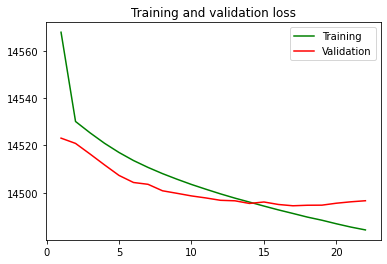

In [14]:
plotTraining('/content/drive/MyDrive/UpWork/ChepVAE/Data/model/VAE1-202109150431-History.json', 3)

# Validation - Reconstruction Error

In [ ]:
wt_path = 'VAE1-202109150431-01-23055.97-20143.87.hdf5'
wt_path = 'VAE1-202109150431-17-14496.03-14495.46.hdf5'
vae.load_weights(os.path.join(config['saveDir'], wt_path))

In [ ]:
mse_value = 0.0
for idx in tqdm(range(len(cdg_val))):
  xx = cdg_val.__getitem__(idx)
  prediction = vae.predict(xx[0])
  error2 = (xx[0] - prediction)**2
  mse_value += np.mean(error2)
mse_value = mse_value / len(cdg_val)
mse_value

100%|██████████| 692/692 [01:03<00:00, 10.89it/s]


1.005154011480381

# Prediction

In [ ]:
data_path = '/content/drive/MyDrive/UpWork/ChepVAE/Data/hdf5/'
output_path = 'prediction.csv'
col_names = ['vec_' + str(i) for i in range(config['latentDim'])]

wt_path = 'VAE1-202109150431-17-14496.03-14495.46.hdf5'
vae.load_weights(os.path.join(config['saveDir'], wt_path))


In [ ]:
# Remove prediction file, if already exist
if os.path.exists(output_path):
  os.remove(output_path)

pbar = tqdm(sorted(os.listdir(data_path)))
for file_name in pbar:
  pbar.set_description("Processing: {}".format(file_name))
  hdf5_path = os.path.join(data_path, file_name)
  data = h5py.File(hdf5_path, 'r')
  df = pd.DataFrame({'Filename':file_name, 'index':range(len(data['data']))})
  prediction = encoder.predict(np.expand_dims(data['data'], axis=3))
  df[col_names] = prediction[2]
  with open(output_path, 'a') as f:
    df.to_csv(f, mode='a', header=f.tell()==0, index=False)
  

Processing: FoilHole_14817213_Data_14817538_14817539_20170415_1328-2614_cor2_DW.h5:   0%|          | 0/465 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
Processing: PHF_FoilHole_14817482_Data_14817538_14817539_20170415_1910-2759_cor2_DW.h5: 100%|██████████| 465/465 [14:10<00:00,  1.83s/it]


In [ ]:
!cp prediction.csv /content/drive/MyDrive/UpWork/ChepVAE/Data/prediction.csv